In [1]:
%reload_ext autoreload
%autoreload 2

## imports

In [2]:
# behavior stats results
from locale import normalize
from operator import inv
import numpy as np
from plot_ult import * 
from scipy import stats 
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import os
import pandas as pd
import numpy as np
from cmaes import CMA
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import torch
import heapq
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib import pyplot as plt
import time
from stable_baselines3 import TD3
torch.manual_seed(0)
from numpy import linspace, pi
from InverseFuncs import *
from monkey_functions import *
from firefly_task import ffacc_real
from env_config import Config
# from cma_mpi_helper import run
# import ray
from pathlib import Path
arg = Config()
import os
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import cm
import scipy.stats as stats



## load data

In [3]:
env=ffacc_real.FireFlyPaper(arg)
env.debug=True
env.terminal_vel=0.05
agent_=TD3.load('trained_agent/paper.zip')
agent=agent_.actor.mu.cpu()

# load data ----------------------------
asd_data_set={}
numhsub,numasub=25,14
fulltrainfolder='persub1cont'
parttrainfolder='persub3of5dp'
for invtag in ['h','a']:
    for isub in range(numhsub):
        thesub="{}sub{}".format(invtag,str(isub))
        evalname=Path(datapath/"human/{}/evaltrain_inv{}sub{}".format(parttrainfolder,invtag,str(isub)))
        fullinverseres=Path(datapath/"human/{}".format(fulltrainfolder))/"inv{}sub{}".format(invtag,str(isub))
        partinverseres=Path(datapath/"human/{}".format(parttrainfolder))/"inv{}sub{}".format(invtag,str(isub))
        # load inv res
        if fullinverseres.is_file():
            asd_data_set['res'+thesub]=process_inv(fullinverseres, usingbest=True, removegr=False)
        # load data
        if Path(datapath/'human/{}'.format(thesub)).is_file():
            with open(datapath/'human/{}'.format(thesub), 'rb') as f:
                states, actions, tasks = pickle.load(f)
            print(len(states))
            asd_data_set['data'+thesub]=states, actions, tasks
        

/Users/yc/Documents/lab_data/human/persub1cont/invhsub0
using ind:  85 final logll :  10.98047685623169
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub1
using ind:  47 final logll :  9.29283959524972
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub2
using ind:  83 final logll :  4.200698069163731
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub3
using ind:  48 final logll :  10.158493995666504
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub4
using ind:  53 final logll :  7.978296484266009
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub5
using ind:  57 final logll :  4.561488900865827
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub6
using ind:  58 final logll :  7.864906413214547
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub7
using ind:  56 final logll :  7.848775114331927
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub8
using ind:  57 final logll :  7.107513700212751
145
/Users/yc/Documents/lab_data

## result stats

In [4]:

# indivividual endpoint stats to svm ----------------------------
asd_data_endpoint={}
asd_data_endpoint_polar={}
for invtag in ['h','a']:
    for isub in range(numhsub):
        thesub="{}sub{}".format(invtag,str(isub))
        if 'data'+thesub in asd_data_set:
            states,_,tasks=asd_data_set['data'+thesub]
            endpoint=np.array([s[-1,:2].tolist() for s in states])
            r,a=xy2pol(endpoint.T, rotation=False)
            endpointpolar=np.stack([a,r]).T
            r,a=xy2pol(tasks.T, rotation=False)
            taskspolar=np.stack([a,r]).T
            asd_data_endpoint[thesub]=(endpoint, tasks)
            asd_data_endpoint_polar[thesub]=(endpointpolar, taskspolar)
            


In [5]:

# same checks
# # xy coord
# for thesub in asd_data_endpoint.keys():
#     f=plt.figure()
#     f.add_subplot(111)
#     (endpoint, tasks)=asd_data_endpoint[thesub]
#     plt.scatter(endpoint[:,0],endpoint[:,1])
#     plt.scatter(tasks[:,0],tasks[:,1])
#     plt.axis('equal')
#     plt.show()

# # polar
# for thesub in asd_data_endpoint_polar.keys():
#     f=plt.figure()
#     f.add_subplot(111, polar=True)
#     (endpoint, tasks)=asd_data_endpoint_polar[thesub]
#     plt.scatter(endpoint[:,0],endpoint[:,1])
#     plt.scatter(tasks[:,0],tasks[:,1])
#     plt.show()


In [6]:

# as a group, regression of the angular err 
xa, ya, xh, yh =[],[],[],[] 
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    if thesub[0]=='a': 
        xa.append(tasks[:,0])
        ya.append(endpoint[:,0])
    else: 
        xh.append(tasks[:,0])
        yh.append(endpoint[:,0])
xa, ya, xh, yh =np.hstack(xa),np.hstack(ya),np.hstack(xh),np.hstack(yh)
stats.linregress(xa, ya) # stop vs target angle, asd
stats.linregress(xh, yh) # stop vs target angle, nt



LinregressResult(slope=1.056995874773694, intercept=0.02016992678766946, rvalue=0.9670703404965991, pvalue=0.0, stderr=0.00461007991700158, intercept_stderr=0.0018739775163653912)

In [7]:

# as a group, regression of the radial err 
xa, ya, xh, yh =[],[],[],[]
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    if thesub[0]=='a': 
        xa.append(tasks[:,1])
        ya.append(endpoint[:,1])
    else: 
        xh.append(tasks[:,1])
        yh.append(endpoint[:,1])
xa, ya, xh, yh =np.hstack(xa),np.hstack(ya),np.hstack(xh),np.hstack(yh)
stats.linregress(xa,ya) # stop vs target dist, asd
stats.linregress(xh, yh) # stop vs target dist, nt



LinregressResult(slope=0.8417892638112805, intercept=0.3008984293567385, rvalue=0.7777420236819556, pvalue=0.0, stderr=0.011275103168845188, intercept_stderr=0.025193294035209392)

In [8]:

# per sub, regression of the angular err 
xa, ya, xh, yh =[],[],[],[]
ares, hres=[],[]
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    if thesub[0]=='a': 
        ares.append(stats.linregress(tasks[:,0],endpoint[:,0]))
    else: 
        hres.append(stats.linregress(tasks[:,0],endpoint[:,0]))

npsummary([a.slope for a in ares]) # angular gain, asd
npsummary([a.slope for a in hres]) # angular gain, nt
stats.ttest_ind([a.slope for a in ares],[a.slope for a in hres]) # angular gain, asd vs nt

npsummary([a.rvalue**2 for a in ares]) # angular fit, asd
npsummary([a.rvalue**2 for a in hres]) # angular fit, nt
stats.ttest_ind([a.rvalue**2 for a in ares],[a.rvalue**2 for a in hres]) # angular fit, asd vs nt

npsummary([a.pvalue for a in ares])
npsummary([a.pvalue for a in hres])
stats.ttest_ind([a.slope for a in ares],[1 for _ in ares]) # angular gain vs 1, asd
stats.ttest_ind([a.slope for a in hres], [1 for _ in hres]) # angular gain vs 1, nt



n samples  14
mean  1.0782213711015538
std  0.08854753394377243
sem  0.023665323890095173
med  1.0644806536458375
range  0.9521516793462586 1.2575656916824387
n samples  25
mean  1.0572084920885296
std  0.0902523863199846
sem  0.01805047726399692
med  1.0487324842934715
range  0.8549457681364024 1.3145607371824901
n samples  14
mean  0.9291076401317585
std  0.0756580570031613
sem  0.020220466275345888
med  0.9479587855440299
range  0.6666748843242715 0.9815522091362191
n samples  25
mean  0.9479052609654336
std  0.09314904181037478
sem  0.018629808362074958
med  0.9699703887417322
range  0.499821119694605 0.9808960208633456
n samples  14
mean  2.5641510070387683e-37
std  9.245177933910903e-37
sem  2.4708777363183695e-37
med  2.4438109613150812e-90
range  9.418606157750488e-127 3.5898114098542755e-36
n samples  25
mean  2.682185188582703e-23
std  1.3139970215356591e-22
sem  2.6279940430713183e-23
med  2.814431051146326e-112
range  2.3142010059363266e-127 6.705462971456758e-22


TtestResult(statistic=3.1053276325374357, pvalue=0.0031862106905805715, df=48.0)

In [9]:

# per sub, regression of the radial err 
xa, ya, xh, yh =[],[],[],[]
ares, hres=[],[]
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    if thesub[0]=='a': 
        ares.append(stats.linregress(tasks[:,1],endpoint[:,1]))
    else: 
        hres.append(stats.linregress(tasks[:,1],endpoint[:,1]))

npsummary([a.slope for a in ares]) # radial gain, asd
npsummary([a.slope for a in hres]) # radial gain, nt

stats.ttest_ind([a.rvalue**2 for a in ares],[a.rvalue**2 for a in hres]) # radial fit, asd vs nt

stats.ttest_ind([a.slope for a in ares],[a.slope for a in hres]) # radial gain, asd vs nt

stats.ttest_ind([a.slope for a in ares],[1 for _ in ares]) # radial gain vs 1, asd
stats.ttest_ind([a.slope for a in hres], [1 for _ in hres]) # radial gain vs 1, nt





n samples  14
mean  0.8646508623035584
std  0.15038131329648383
sem  0.040191096552039646
med  0.8913718926496671
range  0.5496067878059011 1.1240718149351017
n samples  25
mean  0.8467366632089882
std  0.10650371176186162
sem  0.021300742352372323
med  0.8459372648133131
range  0.5932979023821664 1.055092341019347


TtestResult(statistic=-7.049838267678889, pvalue=6.167234294381555e-09, df=48.0)

In [8]:

# per sub, error of first half vs later half (showing no learning)
xa, ya, xh, yh =[],[],[],[]
ares, hres=[],[] # first half
ares2, hres2=[],[] # latter half
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    
    if thesub[0]=='a': 
        ares.append(stats.linregress(tasks[:75,0],endpoint[:75,0]))
        ares2.append(stats.linregress(tasks[75:,0],endpoint[75:,0]))
    else: 
        hres.append(stats.linregress(tasks[:75,0],endpoint[:75,0]))
        hres2.append(stats.linregress(tasks[75:,0],endpoint[75:,0]))

stats.ttest_ind([a.slope for a in ares],[a.slope for a in ares2])
stats.ttest_ind([a.slope for a in hres],[a.slope for a in hres2])


TtestResult(statistic=-0.5490920557380992, pvalue=0.5854877425611552, df=48.0)

In [9]:

# radial
xa, ya, xh, yh =[],[],[],[]
ares, hres=[],[]
ares2, hres2=[],[]
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    
    if thesub[0]=='a': 
        ares.append(stats.linregress(tasks[:75,1],endpoint[:75,1]))
        ares2.append(stats.linregress(tasks[75:,1],endpoint[75:,1]))
    else: 
        hres.append(stats.linregress(tasks[:75,1],endpoint[:75,1]))
        hres2.append(stats.linregress(tasks[75:,1],endpoint[75:,1]))

stats.ttest_ind([a.slope for a in ares],[a.slope for a in ares2])
stats.ttest_ind([a.slope for a in hres],[a.slope for a in hres2])



TtestResult(statistic=-0.6412068740473101, pvalue=0.5244382538064938, df=48.0)

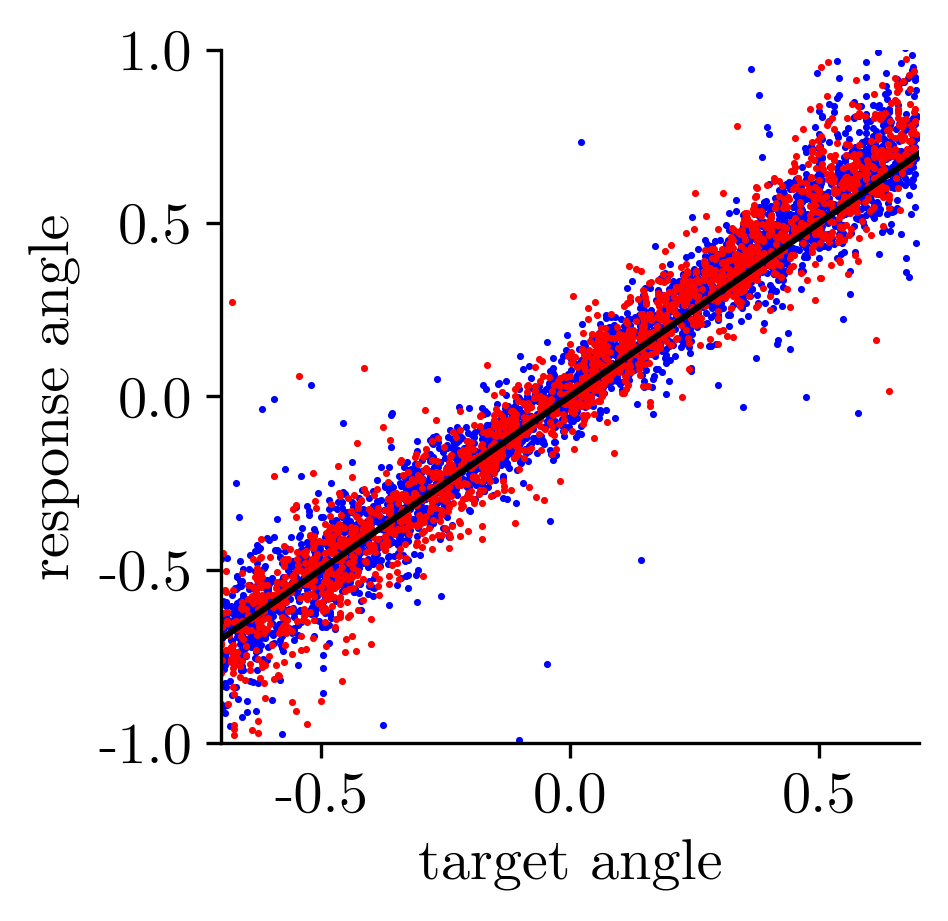

In [10]:

# angular err ------------------------
with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    for thesub in asd_data_endpoint_polar.keys():
        if thesub[0]=='a': color='r'
        else: color='b'
        (endpoint, tasks)=asd_data_endpoint_polar[thesub]
        ax.scatter(tasks[:,0],endpoint[:,0],color=color, s=0.5)
    ax.plot([-0.7,.7],[-0.7,.7],'k')
    ax.set_xlim(-0.7,0.7)
    ax.set_ylim(-1,1)
    quickspine(ax)
    ax.set_xlabel('target angle')
    ax.set_ylabel('response angle')
    # quicksave('asd angular err')


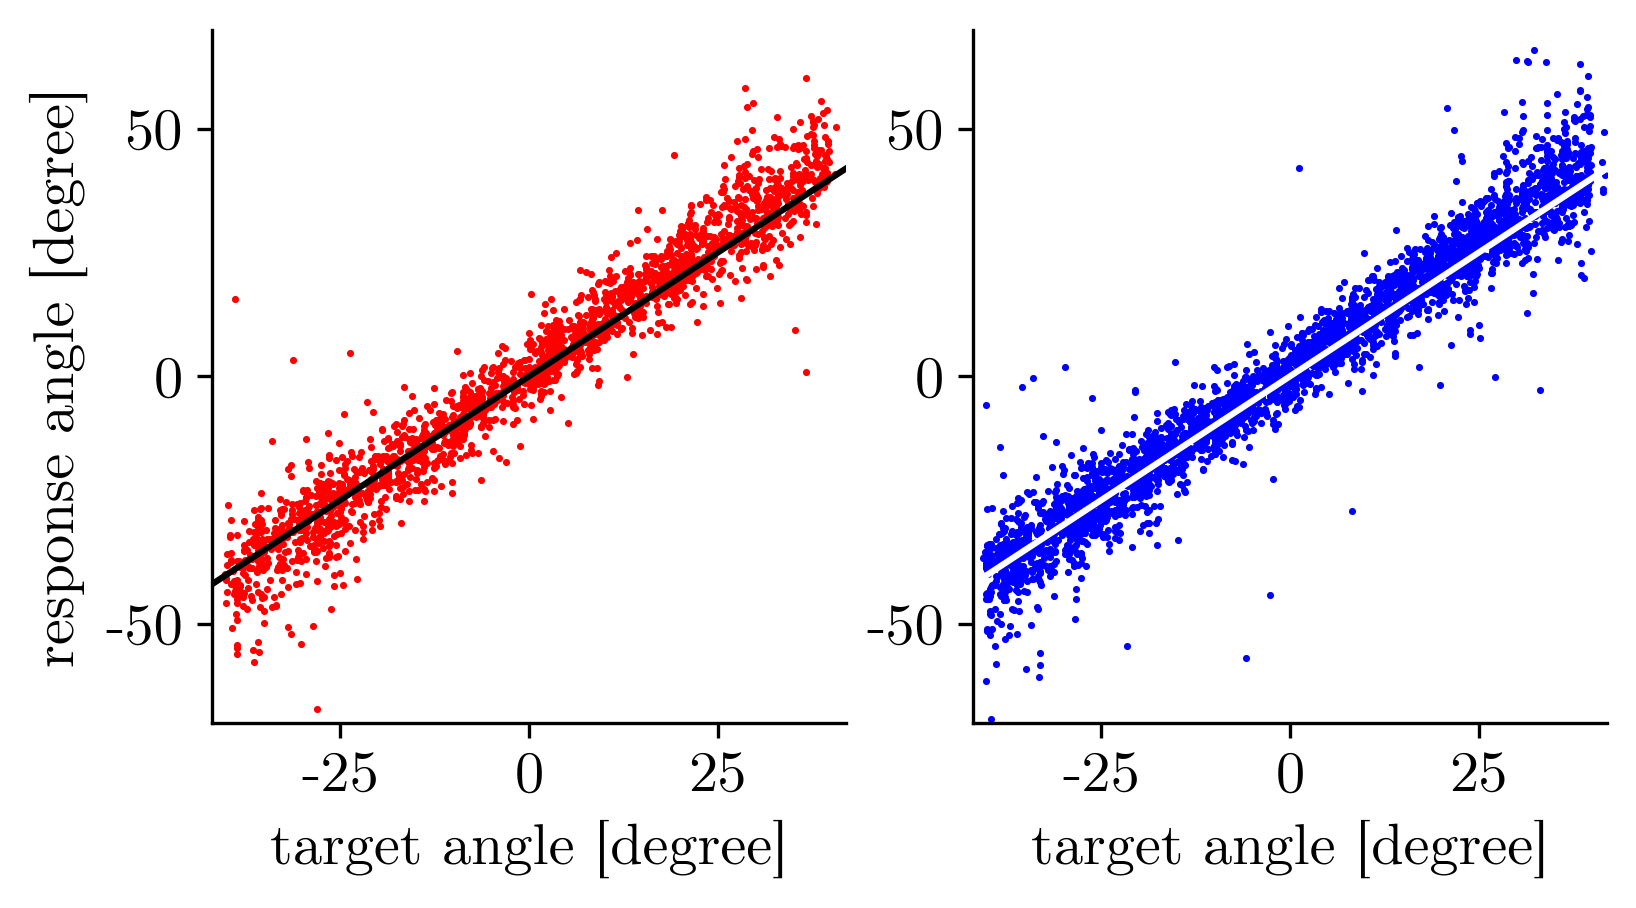

In [11]:

with initiate_plot(6,3,300) as f:
    ax1=f.add_subplot(121)
    ax2=f.add_subplot(122, sharex=ax1, sharey=ax1)
    for thesub in asd_data_endpoint_polar.keys():
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[:,0]*180/pi,endpoint[:,0]*180/pi,color=color, s=0.5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[:,0]*180/pi,endpoint[:,0]*180/pi,color=color, s=0.5)
    ax1.set_xlim(-42,42)
    ax1.set_ylim(-70,70)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target angle [degree]')
    ax2.set_xlabel('target angle [degree]')
    ax1.set_ylabel('response angle [degree]')
    ax1.plot([-50,50],[-50,50],'k')
    ax2.plot([-50,50],[-50,50],'w')
    # quicksave('asd angular err sep')


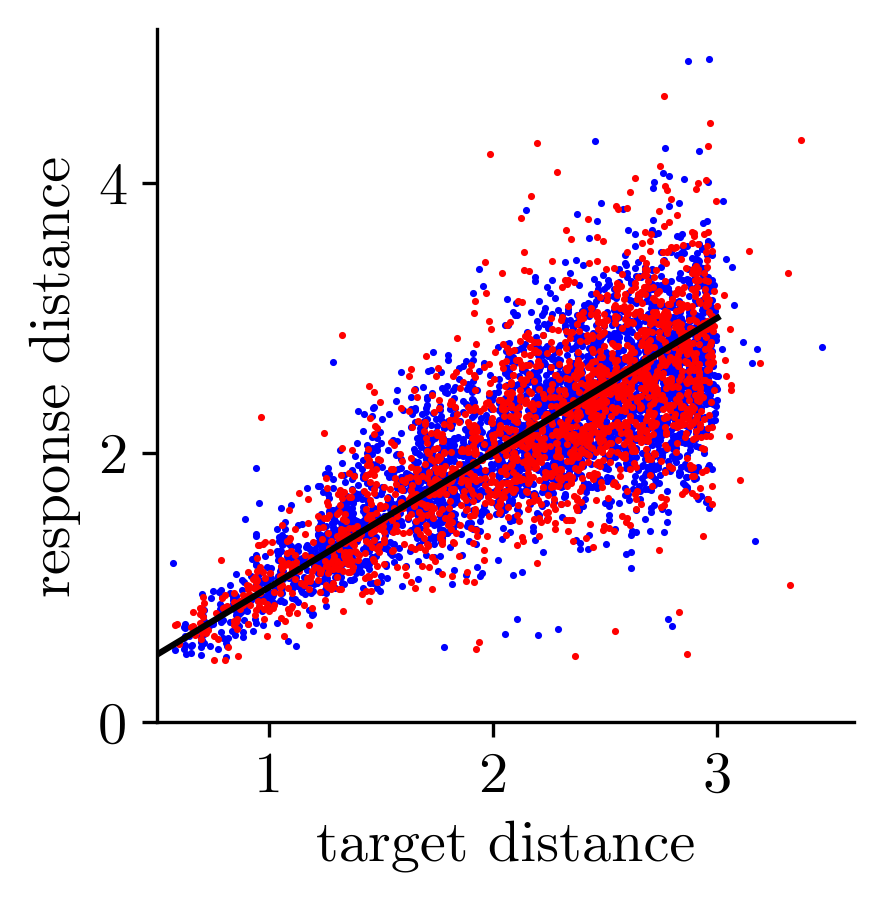

In [12]:

# radial err ------------------------
with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    for thesub in asd_data_endpoint_polar.keys():
        if thesub[0]=='a': color='r'
        else: color='b'
        (endpoint, tasks)=asd_data_endpoint_polar[thesub]
        ax.scatter(tasks[:,1],endpoint[:,1],color=color, s=0.5)
    ax.set_xlim(0.5,None)
    ax.set_ylim(0,None)
    quickspine(ax)
    ax.set_xlabel('target distance')
    ax.set_ylabel('response distance')
    ax.plot([-0.7,3],[-0.7,3],'k')
    # quicksave('asd radiual err')


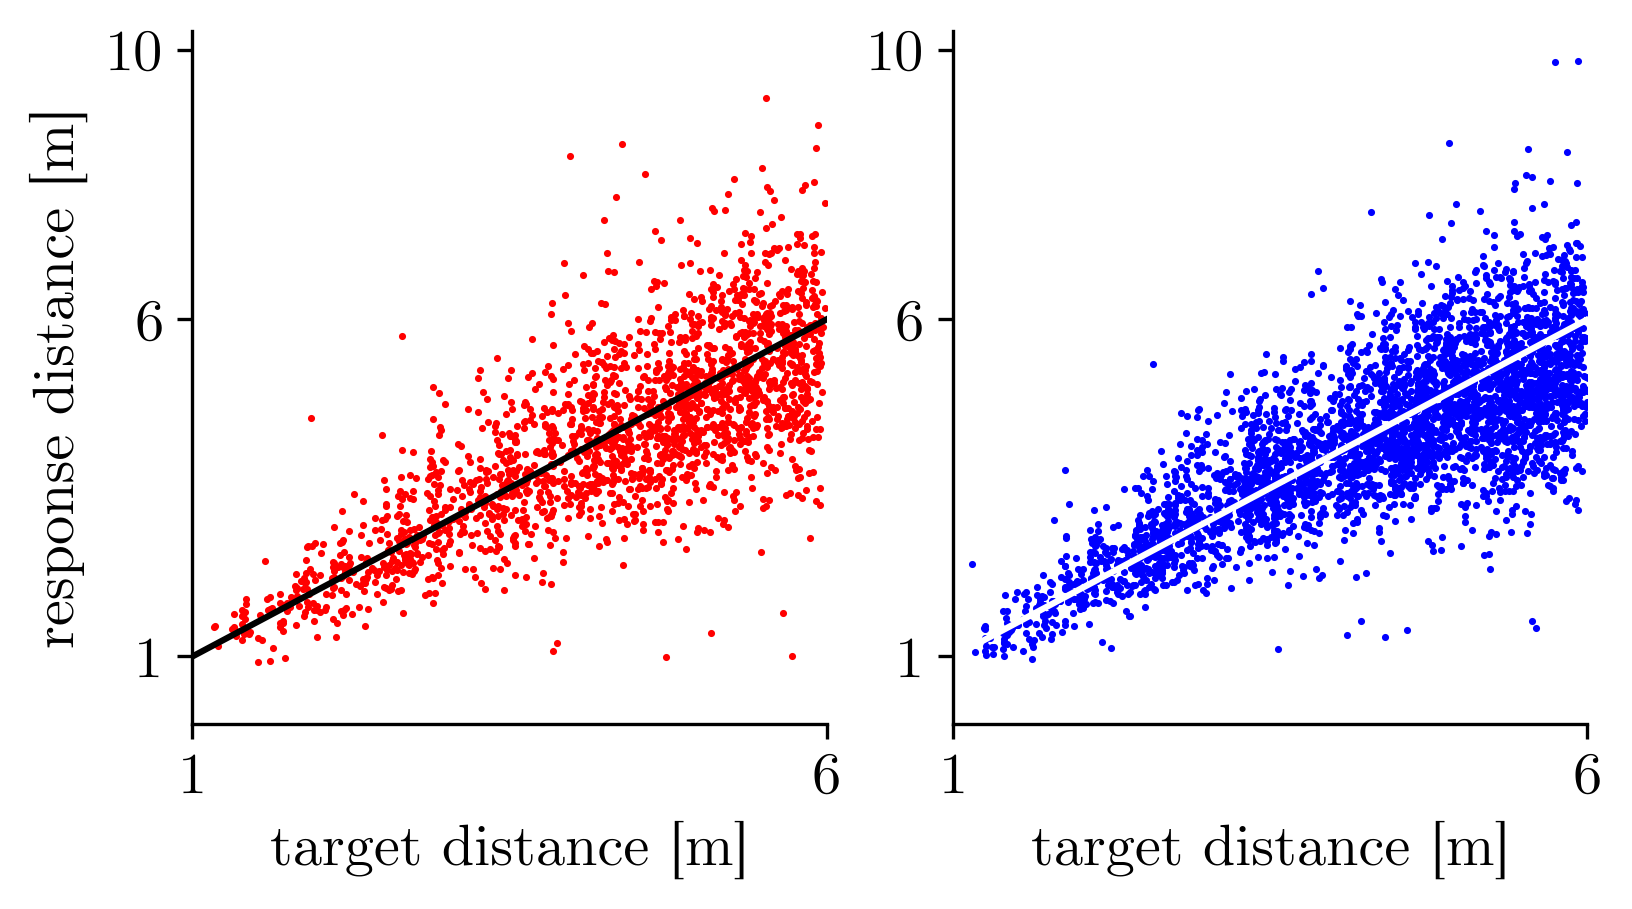

In [13]:

with initiate_plot(6,3,300) as f:
    ax1=f.add_subplot(121)
    ax2=f.add_subplot(122, sharex=ax1, sharey=ax1)
    for thesub in asd_data_endpoint_polar.keys():
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[:,1]*2,endpoint[:,1]*2,color=color, s=0.5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[:,1]*2,endpoint[:,1]*2,color=color, s=0.5)
    ax1.set_xlim(1,6)
    ax1.set_ylim(0,None)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target distance [m]')
    ax2.set_xlabel('target distance [m]')
    ax1.set_ylabel('response distance [m]')
    ax1.plot([1,6],[1,6],'k')
    ax2.plot([1,6],[1,6],'w')
    ax1.set_xticks([1,6])
    ax2.set_xticks([1,6])
    ax1.set_yticks([1,6,10])
    ax2.set_yticks([1,6,10])
    # quicksave('asd radiual err sep')


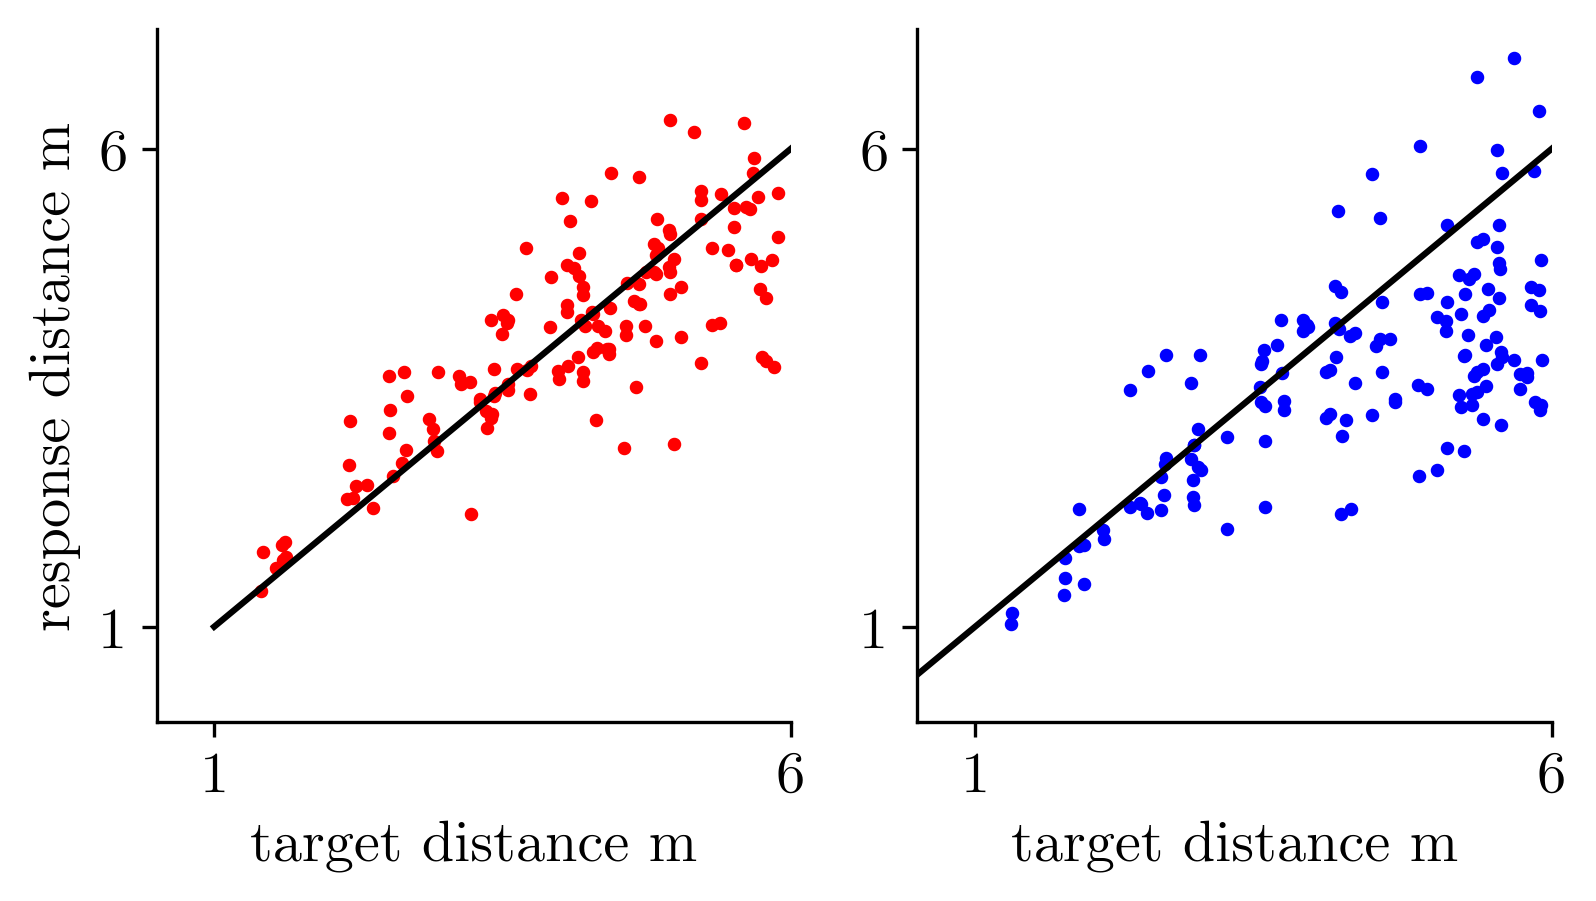

In [14]:

# one example sub
with initiate_plot(6,3,300) as f:
    ax1=f.add_subplot(121)
    ax2=f.add_subplot(122, sharex=ax1, sharey=ax1)
    for thesub in [list(asd_data_endpoint_polar.keys())[0],list(asd_data_endpoint_polar.keys())[-1]]:
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[:,1]*2,endpoint[:,1]*2,color=color, s=5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[:,1]*2,endpoint[:,1]*2,color=color, s=5)
    ax1.set_xlim(0.5,6)
    ax1.set_ylim(0,None)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target distance m')
    ax2.set_xlabel('target distance m')
    ax1.set_ylabel('response distance m')
    ax1.plot([1,6],[1,6],'k')
    ax2.plot([0,6],[0,6],'k')
    ax1.set_xticks([1,6])
    ax2.set_xticks([1,6])
    ax1.set_yticks([1,6])
    ax2.set_yticks([1,6])
    # quicksave('asd radiual err sep example sub')


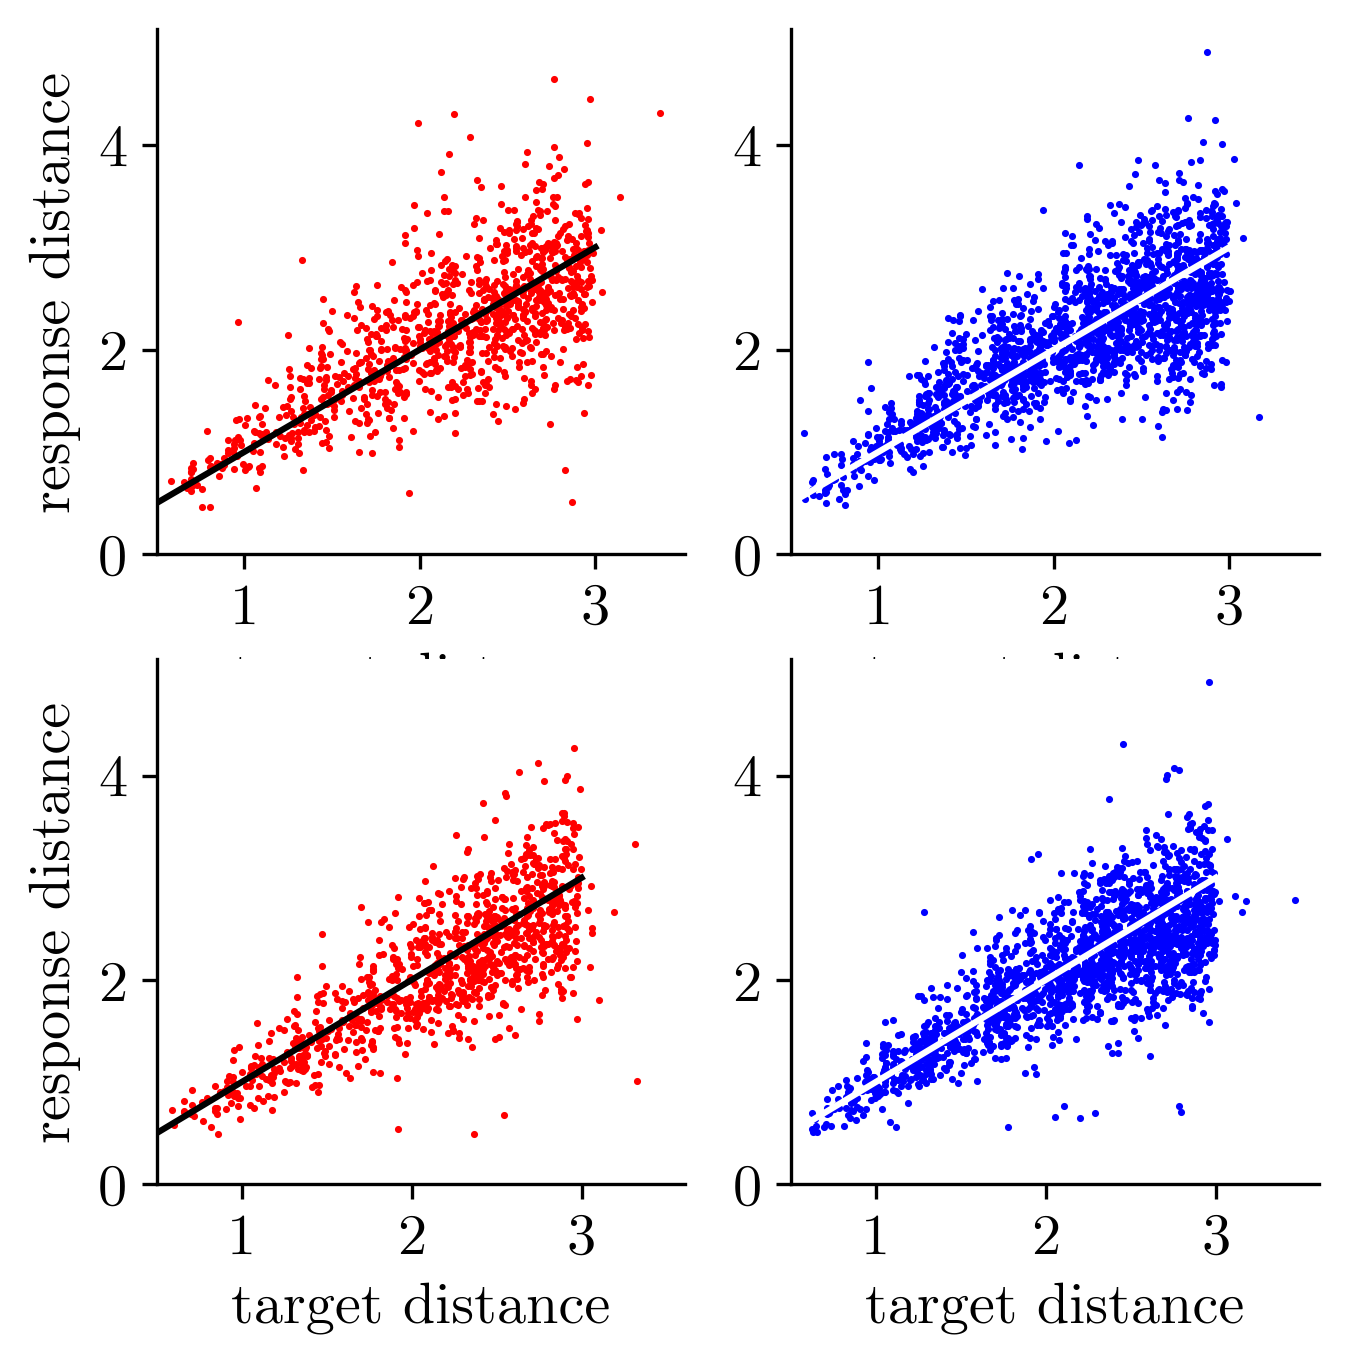

In [15]:

# error of first half vs later half (showing no learning) ------------------------
with initiate_plot(5,5,300) as f:
    ax1=f.add_subplot(221)
    ax2=f.add_subplot(222, sharex=ax1, sharey=ax1)
    for thesub in asd_data_endpoint_polar.keys():
        ntrial=len(asd_data_endpoint_polar[thesub][0])//2
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[:ntrial,1],endpoint[:ntrial,1],color=color, s=0.5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[:ntrial,1],endpoint[:ntrial,1],color=color, s=0.5)
    ax1.set_xlim(0.5,None)
    ax1.set_ylim(0,None)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target distance')
    ax2.set_xlabel('target distance')
    ax1.set_ylabel('response distance')
    ax1.plot([-0.7,3],[-0.7,3],'k')
    ax2.plot([-0.7,3],[-0.7,3],'w')

    ax1=f.add_subplot(223)
    ax2=f.add_subplot(224, sharex=ax1, sharey=ax1)
    for thesub in asd_data_endpoint_polar.keys():
        ntrial=len(asd_data_endpoint_polar[thesub][0])//2
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[ntrial:,1],endpoint[ntrial:,1],color=color, s=0.5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[ntrial:,1],endpoint[ntrial:,1],color=color, s=0.5)
    ax1.set_xlim(0.5,None)
    ax1.set_ylim(0,None)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target distance')
    ax2.set_xlabel('target distance')
    ax1.set_ylabel('response distance')
    ax1.plot([-0.7,3],[-0.7,3],'k')
    ax2.plot([-0.7,3],[-0.7,3],'w')
    quicksave('first vs last half radial err')


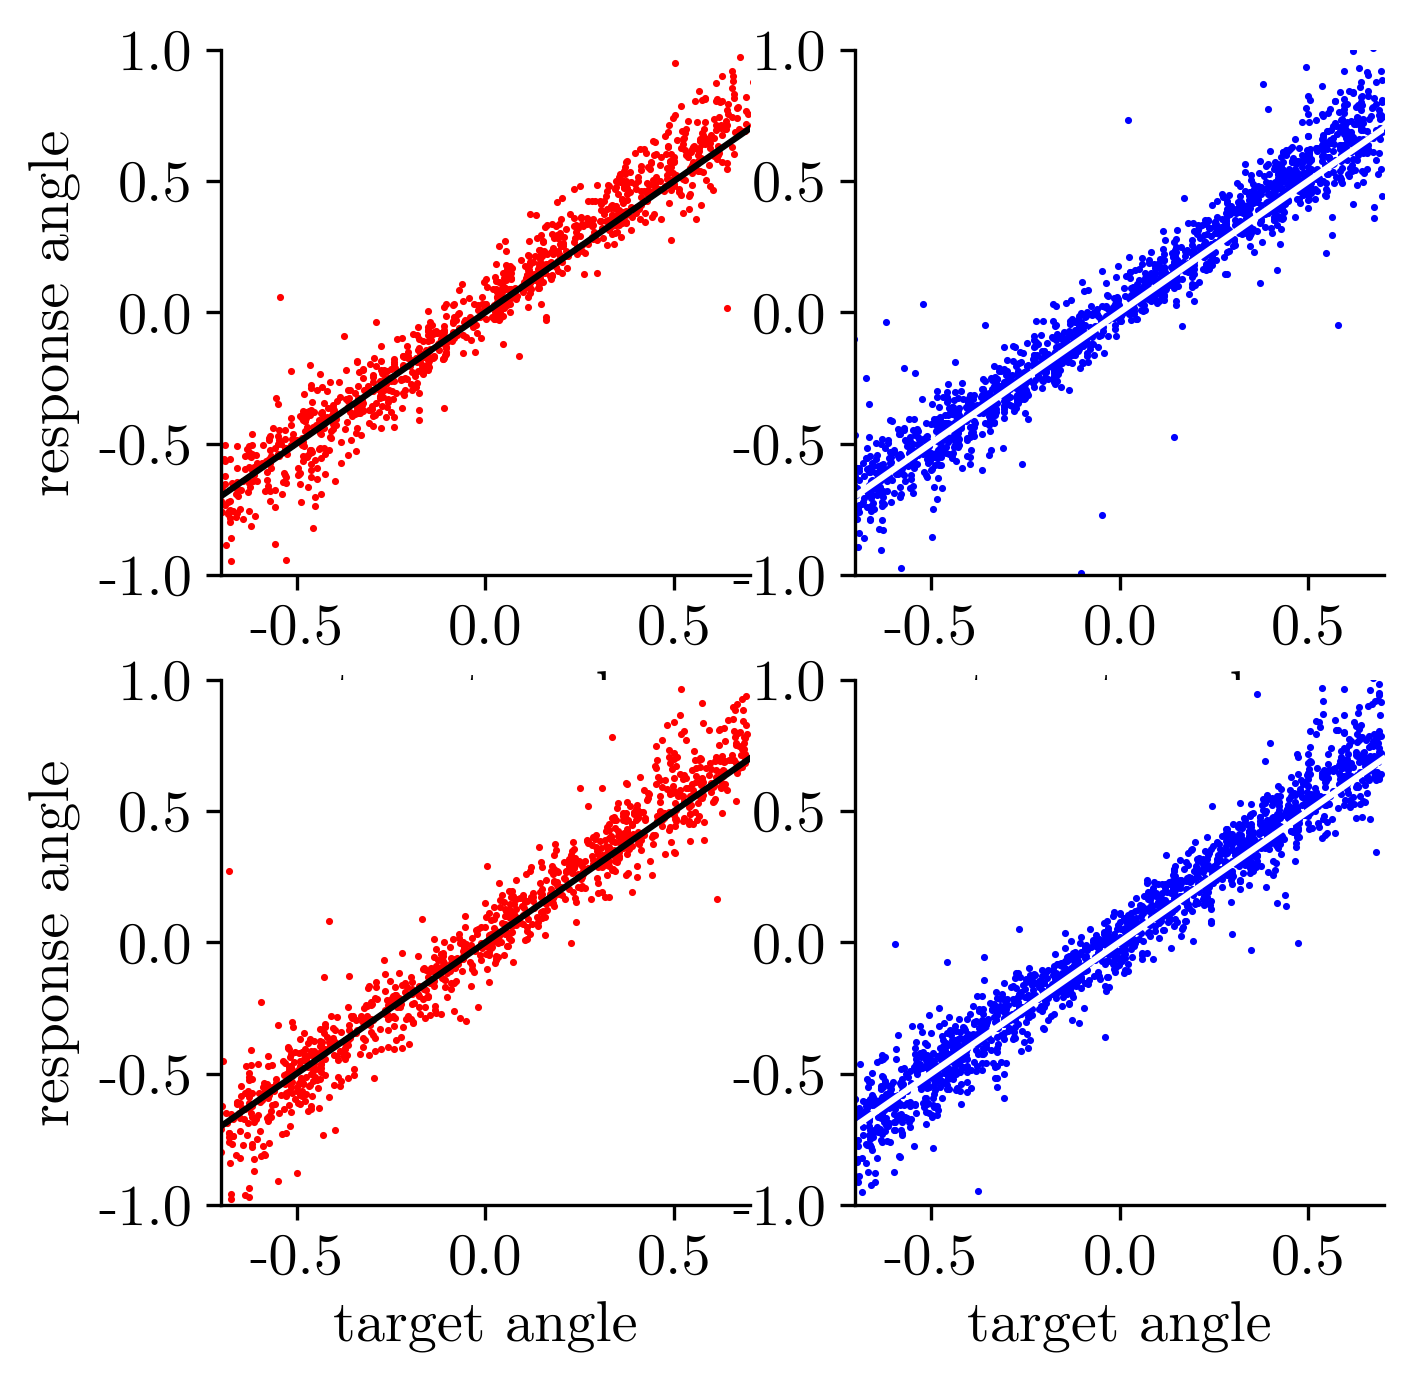

In [16]:

with initiate_plot(5,5,300) as f:
    ax1=f.add_subplot(221)
    ax2=f.add_subplot(222, sharex=ax1, sharey=ax1)
    for thesub in asd_data_endpoint_polar.keys():
        ntrial=len(asd_data_endpoint_polar[thesub][0])//2
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[:ntrial,0],endpoint[:ntrial,0],color=color, s=0.5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[:ntrial,0],endpoint[:ntrial,0],color=color, s=0.5)
    ax1.set_xlim(-0.7,0.7)
    ax1.set_ylim(-1,1)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target angle')
    ax2.set_xlabel('target angle')
    ax1.set_ylabel('response angle')
    ax1.plot([-0.7,.7],[-0.7,.7],'k')
    ax2.plot([-0.7,.7],[-0.7,.7],'w')

    ax1=f.add_subplot(223)
    ax2=f.add_subplot(224, sharex=ax1, sharey=ax1)
    for thesub in asd_data_endpoint_polar.keys():
        ntrial=len(asd_data_endpoint_polar[thesub][0])//2
        if thesub[0]=='a': 
            color='r'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax1.scatter(tasks[ntrial:,0],endpoint[ntrial:,0],color=color, s=0.5)
        else: 
            color='b'
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            ax2.scatter(tasks[ntrial:,0],endpoint[ntrial:,0],color=color, s=0.5)
    ax1.set_xlim(-0.7,0.7)
    ax1.set_ylim(-1,1)
    quickspine(ax1)
    quickspine(ax2)
    ax1.set_xlabel('target angle')
    ax2.set_xlabel('target angle')
    ax1.set_ylabel('response angle')
    ax1.plot([-0.7,.7],[-0.7,.7],'k')
    ax2.plot([-0.7,.7],[-0.7,.7],'w')
    quicksave('first vs last half angular err')


In [17]:

# radial and angular err
polar_err={}
for thesub in asd_data_endpoint.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    err=(endpoint - tasks) # a, r
    polar_err[thesub]=err

# subjects accuracy
accs=[ (len(err[:,0][err[:,0]<0.13])/len(err[:,0])) for _,err in polar_err.items()]
npsummary(accs[:numhsub])
npsummary(accs[numhsub:])



n samples  25
mean  0.9132638583582335
std  0.058958050149787236
med  0.9295774647887324
range  0.7720588235294118 0.993103448275862
n samples  14
mean  0.8896503234920002
std  0.05447934654423182
med  0.8920106847984459
range  0.7534246575342466 0.9794520547945206


In [18]:


# ttest of angular err---------------------------------------
xa, ya, xh, yh =[],[],[],[]
ares, hres=[],[]
ares2, hres2=[],[]
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    session=(endpoint[:,0]/(tasks[:,0])).tolist()    
    if thesub[0]=='a': 
        ares+=session[:len(session)//2]
        ares2+=session[len(session)//2:]
    else: 
        hres+=session[:len(session)//2]
        hres2+=session[len(session)//2:]

stats.ttest_ind(ares,ares2)
stats.ttest_ind(hres,hres2)




TtestResult(statistic=-2.0725010554319825, pvalue=0.038288950731963665, df=3641.0)

In [19]:

# t test of the radial err ---------------------------------------
xa, ya, xh, yh =[],[],[],[]
ares, hres=[],[]
ares2, hres2=[],[]
for thesub in asd_data_endpoint_polar.keys():
    (endpoint, tasks)=asd_data_endpoint_polar[thesub]
    session=(endpoint[:,1]/(tasks[:,1])).tolist()    
    if thesub[0]=='a': 
        ares+=session[:len(session)//2]
        ares2+=session[len(session)//2:]
    else: 
        hres+=session[:len(session)//2]
        hres2+=session[len(session)//2:]

stats.ttest_ind(ares,ares2)
stats.ttest_ind(hres,hres2)



TtestResult(statistic=4.777611762169313, pvalue=1.843888034145154e-06, df=3641.0)

In [20]:

# svm
alltag=[]
allsamples=[]
for invtag in ['h','a']:
    for isub in range(numhsub):
        thesub="{}sub{}".format(invtag,str(isub))
        if thesub in asd_data_endpoint_polar:
            (endpoint, tasks)=asd_data_endpoint_polar[thesub]
            err=polar_err[thesub]
            allsamples.append(np.hstack([endpoint, err]))
            if invtag=='a':
                alltag+=[1]*len(endpoint)
            else:
                alltag+=[0]*len(endpoint)
allsamples=np.abs(np.vstack(allsamples))
alltag=np.array(alltag).astype('int')



project the individual thetas on to the normal vector.



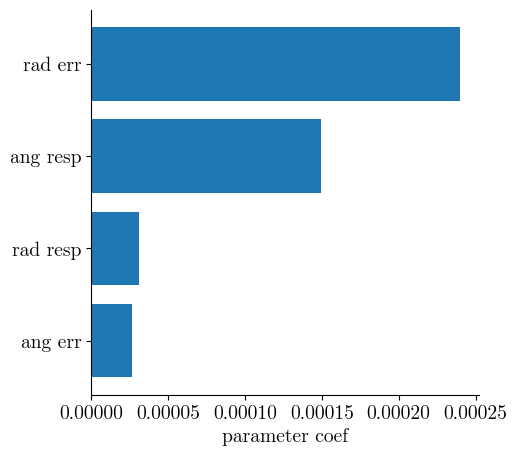

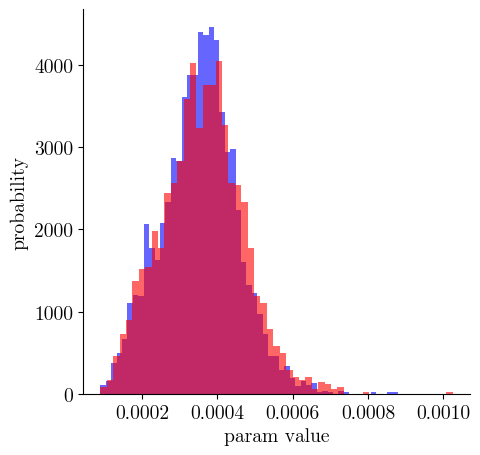

In [21]:

X, Y=allsamples,alltag
X = X[np.logical_or(Y==0,Y==1)][:,:8]
Y = Y[np.logical_or(Y==0,Y==1)]
model = svm.SVC(kernel='linear')
clf = model.fit(X, Y)
f_importances(np.abs(clf.coef_[0]),['rad resp', 'ang resp', 'rad err', 'ang err'])

print('''
project the individual thetas on to the normal vector.
''')
w=clf.coef_[0]
ticks=X[:,:8].dot(w)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(ticks[Y==0],density=True,color='b',bins=55,label='health control',alpha=0.6)
ax.hist(ticks[Y==1],density=True,color='r',bins=55,label='ASD',alpha=0.6)
ax.set_xlabel('param value')
ax.set_ylabel('probability')
quickspine(ax)
# quicksave('svm on end response')


In [23]:

# test cannot seperate
stats.ttest_ind(ticks[Y==0],ticks[Y==1])
stats.ks_2samp(ticks[Y==0],ticks[Y==1], alternative='two-sided')
stats.ks_2samp(ticks[Y==0],ticks[Y==1], alternative='less')
stats.ks_2samp(ticks[Y==0],ticks[Y==1], alternative='greater')
stats.anderson_ksamp([ticks[Y==0],ticks[Y==1]])
# stats.weightstats.ztest(ticks[Y==0],ticks[Y==1])
scipy.special.kl_div(ticks[Y==0][:2019],ticks[Y==1])


# # hit rates and false alarm rates
# hitP = 23/30
# faP  =  4/30
# # z-scores
# hitZ = stats.norm.ppf(hitP)
# faZ  = stats.norm.ppf(faP)
# # d-prime
# dPrime = hitZ-faZ
# print(dPrime)


print('''
conclusion, with svm and subjects end response + err, we cannot tell them apart
''')





conclusion, with svm and subjects end response + err, we cannot tell them apart



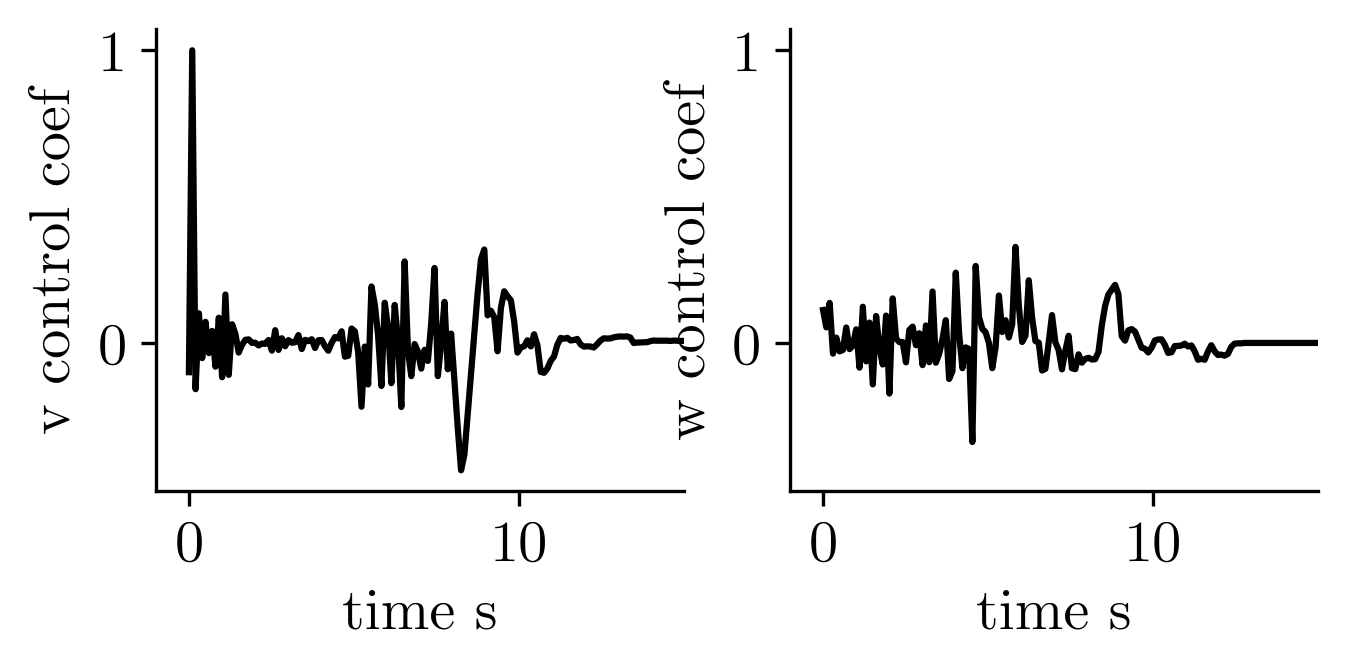

In [24]:

# individusla behavior trajectory to svm ----------------------------

def pad_to_dense(M, maxlen=0):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""
    if maxlen==0:
        maxlen = max(len(r) for r in M)

    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row 
    return Z

alltag=[]
allsamples=[]
maxlen=0
cumsum=[0]
running=0
for invtag in ['h','a']:
    astartind=running
    for isub in range(numhsub):
        thesub="{}sub{}".format(invtag,str(isub))
        if 'data'+thesub in asd_data_set:
            _,actions,tasks=asd_data_set['data'+thesub]
            curmax=max([len(a) for a in actions])
            maxlen=max(maxlen, curmax)
            running+=len(actions)
            cumsum.append(running)
for invtag in ['h','a']:
    for isub in range(numhsub):
        thesub="{}sub{}".format(invtag,str(isub))
        if 'data'+thesub in asd_data_set:
            _,actions,tasks=asd_data_set['data'+thesub]
            paddedv=pad_to_dense([np.array(a[:,0]) for a in actions],maxlen=maxlen)
            paddedw=pad_to_dense([np.array(a[:,1])*sign for sign, a in zip(np.array(tasks[:,1]>0, dtype=int)*-1, actions)],maxlen=maxlen)
            allsamples.append(np.hstack([tasks,paddedv,paddedw]))
            if invtag=='a':
                alltag+=[1]*len(actions)
            else:
                alltag+=[0]*len(actions)


allsamples=np.abs(np.vstack(allsamples))
alltag=np.array(alltag).astype('int')

X, Y=allsamples,alltag
X = X[np.logical_or(Y==0,Y==1)][:,:]
Y = Y[np.logical_or(Y==0,Y==1)]
model = svm.SVC(kernel='linear')
clf = model.fit(X, Y)
# f_importances(np.abs(clf.coef_[0][2:]),list(range(9)))
# quicksave('svm trajectory weights')

with initiate_plot(5,2,300) as f:
    vwcoef=(clf.coef_[0][2:])
    maxcoef=max(vwcoef)
    normvwcoef=vwcoef/maxcoef
    ax=f.add_subplot(121)
    ax.plot(np.linspace(0,maxlen/10,maxlen),(normvwcoef[:maxlen]), color='k')
    quickspine(ax)
    ax.set_xlabel('time s')
    ax.set_ylabel('v control coef')
    # ax.set_ylim(0,1)
    ax.set_xlim(-1,15)
    ax=f.add_subplot(122, sharey=ax)
    ax.plot(np.linspace(0,maxlen/10,maxlen),(normvwcoef[maxlen:]), color='k')
    quickspine(ax)
    ax.set_xlabel('time s')
    ax.set_ylabel('w control coef')
    # ax.set_ylim(0,1)
    ax.set_xlim(-1,15)
    # quicksave('v and w coef of trajectory svm')


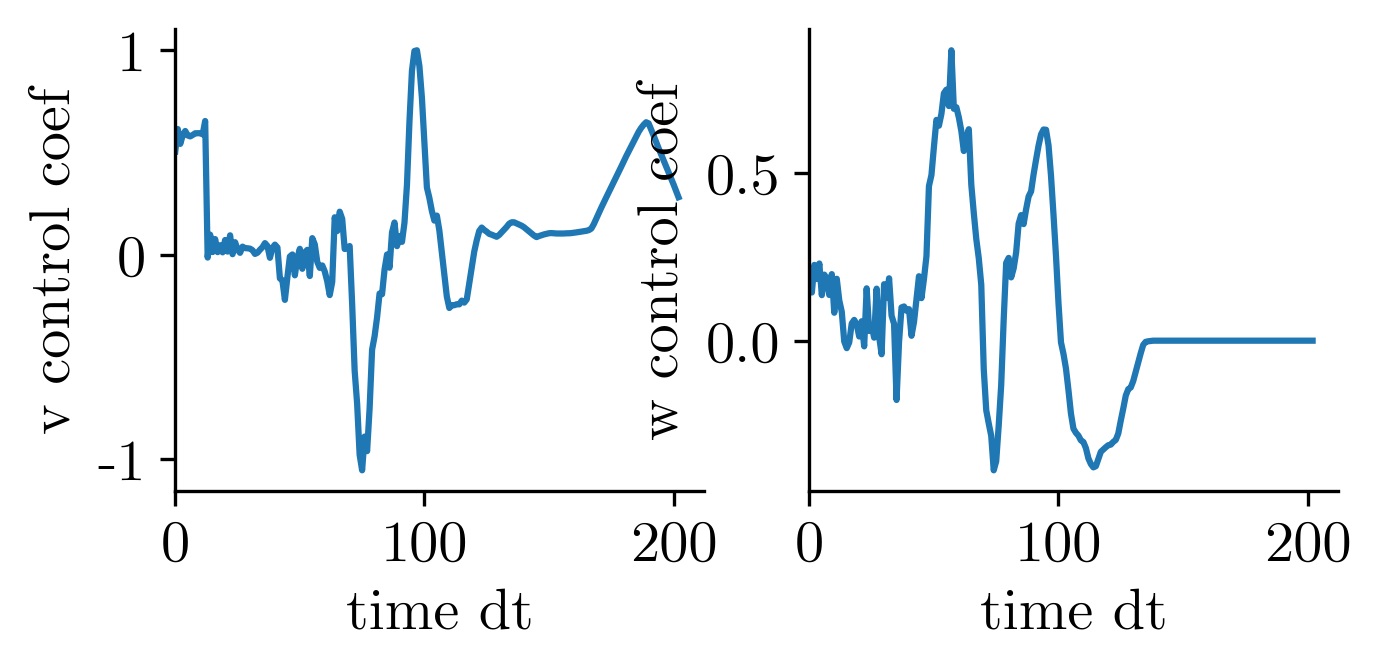


project the individual trajectory on to the normal vector.



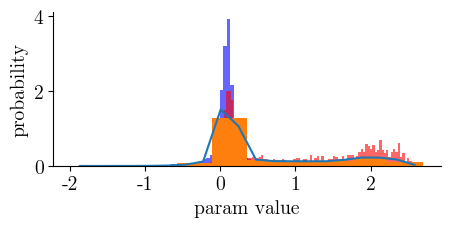

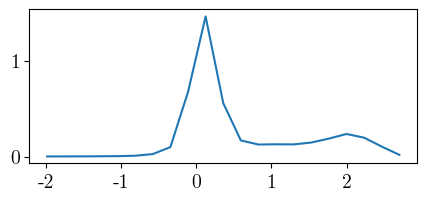

there are some diff. asd seems to be a bi modal distribution. plot individuals to check
the other peak suggest asd behavior. still they are mixed


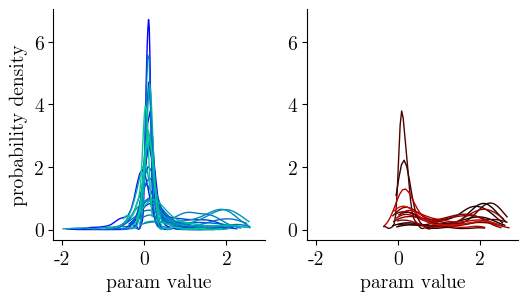

In [25]:

with initiate_plot(5,2,300) as f:
    smoothconvwindow=22
    vwcoef=(clf.coef_[0][2:])
    vcoef=smooth(vwcoef[:maxlen], smoothconvwindow)
    wcoef=smooth(vwcoef[maxlen:], smoothconvwindow)
    maxcoef=max(max(vcoef), max(wcoef))
    vcoef, wcoef=vcoef/maxcoef, wcoef/maxcoef
    ax=f.add_subplot(121)
    ax.plot(vcoef)
    quickspine(ax)
    ax.set_xlabel('time dt')
    ax.set_ylabel('v control coef')
    # ax.set_ylim(0,1)
    ax.set_xlim(0,)
    ax=f.add_subplot(122)
    ax.plot(wcoef)
    quickspine(ax)
    ax.set_xlabel('time dt')
    ax.set_ylabel('w control coef')
    # ax.set_ylim(0,1)
    ax.set_xlim(0,)
    # quicksave('v and w coef of trajectory svm smooth kernalsize{}'.format(smoothconvwindow))


print('''
project the individual trajectory on to the normal vector.
''')
# svm and curve together
w=clf.coef_[0]
ticks=X[:,:].dot(w)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(ticks[Y==0],density=True,color='b',bins=99,label='health control',alpha=0.6)
ax.hist(ticks[Y==1],density=True,color='r',bins=99,label='ASD',alpha=0.6)
ax.set_xlabel('param value')
ax.set_ylabel('probability')
quickspine(ax)
# quicksave('svm on trajectory')

# t test can seperate
stats.ttest_ind(ticks[Y==0],ticks[Y==1])
# stats.ks_2samp(ticks[Y==0],ticks[Y==1])


# raw curve
y_values, bin_edges = np.histogram(ticks, bins=20,density=True)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers, y_values, '-')
plt.hist(ticks, density=True)
plt.show()

# smoothed curve
density = stats.gaussian_kde(ticks)
n, x = np.histogram(ticks, bins=20,density=True)
plt.plot(x, density(x))
# plt.hist(ticks, density=True,bins=20,)
plt.show()

# per subject curve
print('there are some diff. asd seems to be a bi modal distribution. plot individuals to check')
w=clf.coef_[0]
fig = plt.figure(figsize=(6,3))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122, sharey=ax1,sharex=ax1)
for i, (s,e) in enumerate(zip(cumsum[:-1], cumsum[1:])):
    ticks=X[s:e,:].dot(w)
    if s>=astartind: # ASD
        cm_subsection = linspace(0,1, 25) 
        colors = [ cm.gist_heat(x) for x in cm_subsection ]
        # ax2.hist(ticks,density=True,bins=33,alpha=0.6)
        density = stats.gaussian_kde(ticks)
        n, x = np.histogram(ticks, bins=33,density=True)
        ax2.plot(x, density(x),linewidth=1, color=colors[i-numhsub])
    else: # NT
        cm_subsection = linspace(0, 0.8, 25) 
        colors = [ cm.winter(x) for x in cm_subsection ]
        # ax1.hist(ticks,density=True,bins=33,alpha=0.6)
        density = stats.gaussian_kde(ticks)
        n, x = np.histogram(ticks, bins=33,density=True)
        ax1.plot(x, density(x), linewidth=1, color=colors[i])

    ax1.set_xlabel('param value')
    ax1.set_ylabel('probability density')
    quickspine(ax1)
    ax2.set_xlabel('param value')
    quickspine(ax2)
# quicksave('asd behavior trajectory svm')
print('the other peak suggest asd behavior. still they are mixed')




